# Think Bayes solutions: Chapter 4

This notebook presents solutions to exercises in Think Bayes.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

from thinkbayes2 import Suite
import thinkplot

% matplotlib inline

**Exercise 4.1** Suppose that instead of observing coin tosses directly, you measure the outcome using an instrument that is not always correct. Specifically, suppose there is a probability `y` that an actual heads is reported as tails, or actual tails reported as heads.

Write a class that estimates the bias of a coin given a series of outcomes and the value of `y`.

How does the spread of the posterior distribution depend on `y`?

**Solution**

In [2]:
class UnreliableCoin(Suite):
    
    def __init__(self, prior, y):
        """
        prior: seq or map
        y: probability of accurate measurement
        """
        Suite.__init__(self, prior)
        self.y = y
    
    def Likelihood(self, data, hypo):
        """
        data: outcome of unreliable measurement, either 'H' or 'T'
        hypo: probability of heads, 0-100
        """
        x = hypo / 100
        y = self.y
        if data == 'H':
            return x*y + (1-x)*(1-y)
        else:
            return x*(1-y) + (1-x)*y

Now let's initialize one with `y=0.9`:

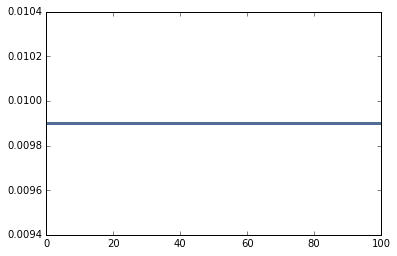

In [3]:
prior = range(0, 101)
suite = UnreliableCoin(prior, y=0.9)
thinkplot.Pdf(suite)

And update with 3 heads and 7 tails.

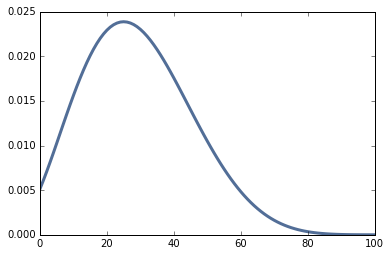

In [4]:
for outcome in 'HHHTTTTTTT':
    suite.Update(outcome)
    
thinkplot.Pdf(suite)

Now let's try it out with different values of `y`:

In [5]:
def compute_prior(y):
    prior = range(0, 101)
    suite = UnreliableCoin(prior, y=y)
    for outcome in 'HHHTTTTTTT':
        suite.Update(outcome)
    
    thinkplot.Pdf(suite, label='y=%g' % y)

The posterior distribution gets wider as the measurement gets less reliable.

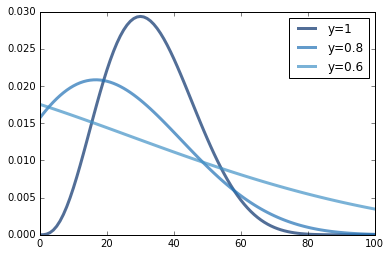

In [6]:
compute_prior(1)
compute_prior(0.8)
compute_prior(0.6)
thinkplot.config(legend=True)

At `y=0.5`, the measurement provides no information, so the posterior equals the prior:

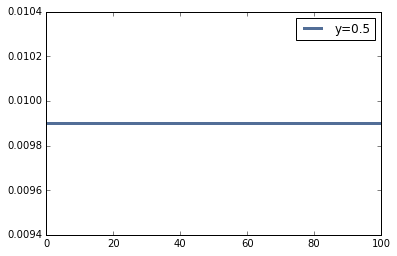

In [7]:
compute_prior(0.5)
thinkplot.config(legend=True)

As the coin gets less reliable (below `y=0.5`) the distribution gets narrower again.  In fact, a measurement with `y=0` is just as good as one with `y=1`, provided that we know what `y` is.

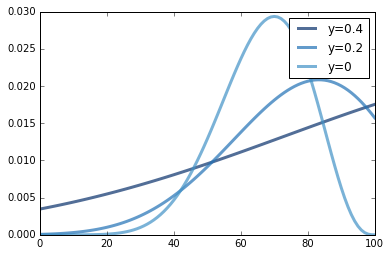

In [8]:
compute_prior(0.4)
compute_prior(0.2)
compute_prior(0.0)
thinkplot.config(legend=True)

**Exercise 4.2:** This exercise is inspired by a question posted by a “redditor” named dominosci on Reddit’s statistics “subreddit” at http://reddit.com/r/statistics.

Reddit is an online forum with many interest groups called subreddits. Users, called redditors, post links to online content and other web pages. Other redditors vote on the links, giving an “upvote” to high-quality links and a “downvote” to links that are bad or irrelevant.

A problem, identified by dominosci, is that some redditors are more reliable than others, and Reddit does not take this into account.

The challenge is to devise a system so that when a redditor casts a vote, the estimated quality of the link is updated in accordance with the reliability of the redditor, and the estimated reliability of the redditor is updated in accordance with the quality of the link.

One approach is to model the quality of the link as the probability of garnering an upvote, and to model the reliability of the redditor as the probability of correctly giving an upvote to a high-quality item.

Write class definitions for redditors and links and an update function that updates both objects whenever a redditor casts a vote.

**Solution**  Here's one possible model:

* Each article has a quality Q, which is the probability of eliciting an upvote from a completely reliab;e redditor. 
* Each user has a reliability R, which is the probability of giving an upvote to an item with Q=1.
* The probability that a redditor with reliability R gives an upvote to an item with quality Q is

`R*Q + (1-R) * (1-Q)`

Now when a redditor votes on a item, we simultaneously update our belief about the redditor and the item.  Here's the class that represents redditors:

In [9]:
class Redditor(Suite):
    """Represents hypotheses about the trustworthiness of a redditor."""

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: integer value of r, the prob of a correct vote (0-100)
        data: (vote, q) pair, where vote is 'up' or 'down' and
              q is the mean quality of the link
        """
        r = hypo / 100.0
        vote, q = data

        if vote == 'up':
            return r * q + (1-r) * (1-q)
        elif vote == 'down':
            return r * (1-q) + (1-r) * q
        else:
            return 0

And the class that represents items:

In [10]:
class Item(Suite):
    """Represents hypotheses about the quality of an item."""

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: integer value of x, the prob of garnering an upvote
        data: (vote, t) pair, where vote is 'up' or 'down' and
              t is the mean trustworthiness of the redditor
        """
        x = hypo / 100.0
        vote, r = data

        if vote == 'up':
            return x * r + (1-x) * (1-r)
        elif vote == 'down':
            return x * (1-r) + (1-x) * r
        else:
            return 0

Suppose we start with a redditor who has demonstrated some reliability:

0.6699999999999996

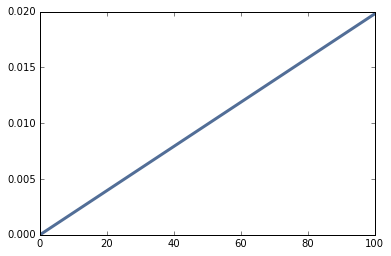

In [11]:
from thinkbayes2 import Beta

redditor = Redditor(label='redditor')
beta = Beta(2, 1)
for val, prob in beta.MakePmf().Items():
    redditor.Set(val*100, prob)
    
thinkplot.Pdf(redditor)
mean_r = redditor.Mean() / 100.0
mean_r

And a completely unknown item:

0.5000000000000001

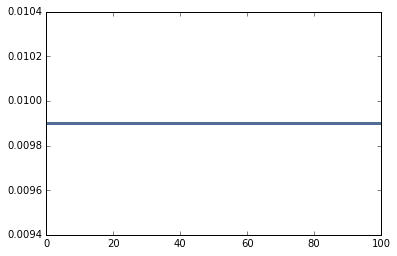

In [12]:
item = Item(range(0, 101), label='item')

thinkplot.Pdf(item)
mean_q = item.Mean() / 100.0
mean_q

We update the priors simultaneously, each using the mean value of the other:

In [13]:
redditor.Update(('up', mean_q))
item.Update(('up', mean_r))

0.4999999999999999

And here are the results.  Since we knew nothing about the item, the vote provides no information about the redditor:

67.0 (22.0, 98.0)


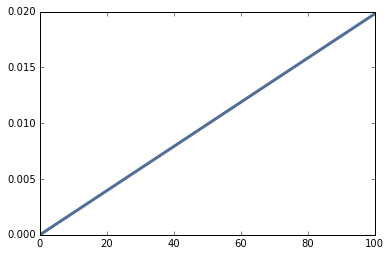

In [14]:
thinkplot.Pdf(redditor)
print(redditor.Mean(), redditor.CredibleInterval(90))

But since we think the redditor is reliable, the vote provides some information about the item:

55.78 (7, 97)


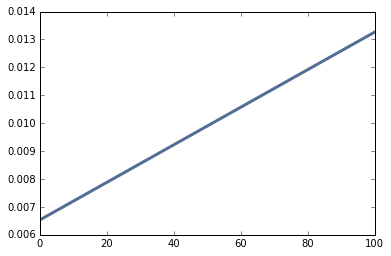

In [15]:
thinkplot.Pdf(item)
print(item.Mean(), item.CredibleInterval(90))

After the upvote, the mean quality of the item increases to about 56%.

The model I used to compute likelihoods is not the only choice.  As an alternative, I could have used something like [item response theory](https://en.wikipedia.org/wiki/Item_response_theory), which we'll see in Chapter 12.